<a href="https://colab.research.google.com/github/igor531205/applied_machine_learning_tasks/blob/main/hw6_torch_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow

# Mount Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


Standard libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

PyTorch libraries

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.models import convnext_large, efficientnet_v2_m

Download dataset CIFAR10

In [ ]:
# List of class labels for CIFAR10 dataset
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 170M/170M [00:10<00:00, 15.7MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Create data loaders

In [ ]:
# Number of samples per batch
batch_size = 1024

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Iterate over test dataloader
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1024, 3, 32, 32])
Shape of y: torch.Size([1024]) torch.int64


Select device for training

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Creating Model ConvNeXt_Large

In [ ]:
# ConvNeXt_Large model
model = convnext_large(weights='DEFAULT')
model.classifier[2] = nn.Linear(model.classifier[2].in_features, len(classes))
model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:30<00:00, 26.2MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

Loss function and optimizer for train model

In [ ]:
# Loss function for classification
loss_fn = nn.CrossEntropyLoss()
# SGD optimizer with a learning rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

Function for Train model

In [ ]:
# Training function
def train(dataloader, model, loss_fn, optimizer):
    # Total number of samples in train dataset
    size = len(dataloader.dataset)
    # Set model to training mode
    model.train()
    # Train loop
    for batch, (X, y) in enumerate(dataloader):
        # Move data and labels to selected device
        X, y = X.to(device), y.to(device)

        # Prediction
        pred = model(X)
        # Calculate loss
        loss = loss_fn(pred, y)

        # Backpropagation
        # Calculate gradients
        loss.backward()
        # Update weights
        optimizer.step()
        # Reset gradients
        optimizer.zero_grad()

        # Print loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Function for Test model

In [ ]:
# Testing function
def test(dataloader, model, loss_fn):
    # Total number of samples in test dataset
    size = len(dataloader.dataset)
    # Number of batches
    num_batches = len(dataloader)
    # Set model to evaluation mode
    model.eval()
    test_loss, correct = 0, 0
    # Disable gradient calculate
    with torch.no_grad():
        # Test loop
        for X, y in dataloader:
            # Move data and labels to selected device
            X, y = X.to(device), y.to(device)
            # Prediction
            pred = model(X)
            # Calculate test loss
            test_loss += loss_fn(pred, y).item()
            # Count predictions
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Average test loss
    test_loss /= num_batches
    # Accuracy
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Train model

In [ ]:
# Number of epochs
epochs = 5
# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.419867  [ 1024/50000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.398290 

Epoch 2
-------------------------------
loss: 0.430819  [ 1024/50000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.398181 

Epoch 3
-------------------------------
loss: 0.426123  [ 1024/50000]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.398094 

Epoch 4
-------------------------------
loss: 0.445376  [ 1024/50000]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.397862 

Epoch 5
-------------------------------
loss: 0.427703  [ 1024/50000]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.397742 

Done!


Saving Model

In [ ]:
torch.save(model.state_dict(), "model_c.pth")
print("Saved PyTorch Model State to model_c.pth")

Saved PyTorch Model State to model.pth


Loading Model

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/model_c.pth"))
model.to(device)

Eval model

In [ ]:
# Function to visualize predictions
def visualize_predictions(model, dataset, classes, device, num_samples=4):
    model.eval()
    fig, axs = plt.subplots(1, num_samples, figsize=(12, 3))
    for i in range(num_samples):
        # Randomly sample from test dataset
        random_index = random.randint(0, len(dataset) - 1)
        x, y = dataset[random_index][0], dataset[random_index][1]

        # Move data to selected device
        x = x.unsqueeze(0).to(device)
        # Prediction
        with torch.no_grad():
            pred = model(x)
            confidence = torch.softmax(pred, dim=1).max().item()
            predicted_class = pred.argmax(1).item()

        # Plot image and predictions
        axs[i].imshow(x.cpu().squeeze().permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(f"Pred: {classes[predicted_class]}\nConf: {confidence:.2f}\nActual: {classes[y]}")

    plt.show()

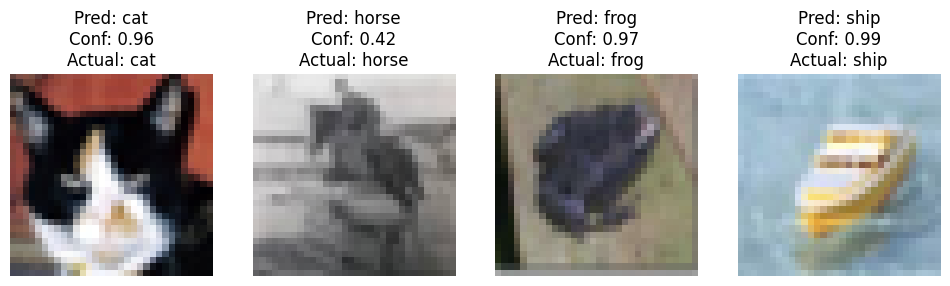

In [ ]:
# Visualize random predictions
visualize_predictions(model, test_data, classes, device)

In [ ]:
all_preds = []
all_labels = []

# Disable gradient calculate
with torch.no_grad():
    # Loop
    for X, y in test_dataloader:
        # Move data to selected device
        X, y = X.to(device), y.to(device)
        # Prediction
        pred = model(X)
        # Append predicted labels to list
        all_preds.extend(pred.argmax(1).cpu().numpy())
        # Append real labels to list
        all_labels.extend(y.cpu().numpy())

# Calculate and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
cm_df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,896,14,16,3,4,1,3,7,41,15
automobile,11,926,0,1,2,0,4,0,9,47
bird,31,0,843,17,45,18,30,15,1,0
cat,6,1,31,698,36,143,34,37,8,6
deer,5,1,39,20,841,10,12,70,1,1
dog,2,1,12,90,28,822,6,38,1,0
frog,7,0,12,29,24,10,913,1,1,3
horse,13,2,19,8,36,42,4,874,1,1
ship,36,10,2,2,0,0,3,1,937,9
truck,16,56,0,2,0,0,0,3,14,909


In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.90      0.89      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.87      0.84      0.85      1000
         cat       0.80      0.70      0.75      1000
        deer       0.83      0.84      0.83      1000
         dog       0.79      0.82      0.80      1000
        frog       0.90      0.91      0.91      1000
       horse       0.84      0.87      0.85      1000
        ship       0.92      0.94      0.93      1000
       truck       0.92      0.91      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Creating Model EfficientNetV2_M

In [ ]:
# EfficientNetV2_M model
model = efficientnet_v2_m(weights='DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 129MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

Loss function and optimizer for train model

In [ ]:
# SGD optimizer with a learning rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

Train model

In [ ]:
# Number of epochs
epochs = 5
# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.124018  [ 1024/50000]
Test Error: 
 Accuracy: 76.3%, Avg loss: 1.099520 

Epoch 2
-------------------------------
loss: 0.127713  [ 1024/50000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 1.096400 

Epoch 3
-------------------------------
loss: 0.114154  [ 1024/50000]
Test Error: 
 Accuracy: 76.3%, Avg loss: 1.102881 

Epoch 4
-------------------------------
loss: 0.121110  [ 1024/50000]
Test Error: 
 Accuracy: 76.3%, Avg loss: 1.099913 

Epoch 5
-------------------------------
loss: 0.124707  [ 1024/50000]
Test Error: 
 Accuracy: 76.3%, Avg loss: 1.093106 

Done!


Saving Model

In [ ]:
torch.save(model.state_dict(), "model_e.pth")
print("Saved PyTorch Model State to model_e.pth")

Loading Model

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/model_e.pth"))
model.to(device)

Eval model

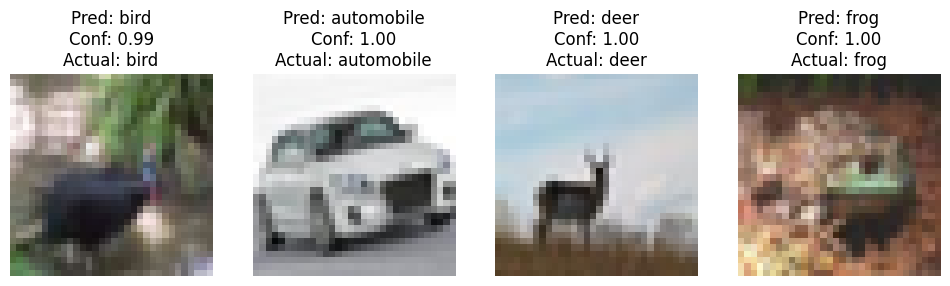

In [ ]:
# Visualize random predictions
visualize_predictions(model, test_data, classes, device)

In [ ]:
# Random sample
random_index = random.randint(0, len(test_data) - 1)
x, y = test_data[random_index][0], test_data[random_index][1]

# Set model to evaluation mode
model.eval()
# Disable gradient calculate
with torch.no_grad():
    # Move data to selected device
    x = x.unsqueeze(0).to(device)
    # Prediction
    pred = model(x)
    # Get predicted and actual class labels
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "bird", Actual: "bird"


In [ ]:
all_preds = []
all_labels = []

# Disable gradient calculate
with torch.no_grad():
    # Loop
    for X, y in test_dataloader:
        # Move data to selected device
        X, y = X.to(device), y.to(device)
        # Prediction
        pred = model(X)
        # Append predicted labels to list
        all_preds.extend(pred.argmax(1).cpu().numpy())
        # Append real labels to list
        all_labels.extend(y.cpu().numpy())

# Calculate and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
cm_df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,819,14,30,15,21,3,5,11,51,31
automobile,14,873,3,6,1,2,11,2,21,67
bird,63,1,666,84,76,32,50,21,5,2
cat,16,9,68,580,61,149,58,26,11,22
deer,13,1,58,55,736,33,32,60,8,4
dog,9,2,43,217,41,619,17,47,1,4
frog,4,2,36,58,38,18,834,1,2,7
horse,18,2,21,40,52,46,4,797,2,18
ship,63,25,5,15,6,0,1,2,870,13
truck,33,58,7,15,1,8,6,12,25,835


In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.82      0.80      1000
  automobile       0.88      0.87      0.88      1000
        bird       0.71      0.67      0.69      1000
         cat       0.53      0.58      0.56      1000
        deer       0.71      0.74      0.72      1000
         dog       0.68      0.62      0.65      1000
        frog       0.82      0.83      0.83      1000
       horse       0.81      0.80      0.81      1000
        ship       0.87      0.87      0.87      1000
       truck       0.83      0.83      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [ ]:
# Unmount Google Drive
drive.flush_and_unmount()

Согласно официальной документации [Classification models](https://pytorch.org/vision/main/models.html#classification) Модели обучены на датасете ImageNet-1K и показывают следующие результаты точности:


*   Модель  ConvNeXt_Large  имеет Acc@1=84.414, Acc@5=96.976
*   Модель EfficientNetV2_M имеет Acc@1=85.112, Acc@5=97.156

Похоже несмотря на то, что Модель EfficientNetV2_M обученная на датасете ImageNet-1K показывает лучше результаты точности, Модель ConvNeXt_Large лучше адаптировалась к новым данным (датасет CIFAR10), поэтому показала лучший результат на новых данных.
